In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import patches

In [2]:
from rom_decadal_lib import *

<Figure size 640x480 with 0 Axes>

In [ ]:
ORAS5_indices = xr.open_dataset('indices/ORAS5_obs_indices.nc')
ORAS5_indices = ORAS5_indices.sel(time=slice('1985',None))
T = declim(ORAS5_indices.nino34)
h = declim(ORAS5_indices.h_eq)

full_y =xr.concat((T,h),dim='v').assign_coords({'v':np.array(('T','h'))})
full_dy = full_y.diff('time',label='lower') # this is the dy at the time it starts from

In [ ]:
# Fit indices to 10 year rolling windows
start_years = np.arange(1985,2024-9)

# I wouldn't normally put out empty buckets to fill with a for loop like this,
# but it makes more sense with the rolling window and multiple functions for
# readability and memory's sake

wk_10 = np.zeros(start_years.shape[0]) # Wyrtki index
bj_10 = np.zeros(start_years.shape[0]) # Bjerknes index
amp_10 = np.zeros(start_years.shape[0]) # Amplitude
lag_10 = np.zeros(start_years.shape[0]) # Lag of peak cross-correlation


for i, start_year in enumerate(start_years):
    time_slice = slice(str(start_year)+'-01',str(start_year+9)+'-12')
    #print(full_y.sel(time=time_slice).shape)
    
    # Bjerknes and Wyrtki indices
    bwj = calc_BWJ(full_y.sel(time=time_slice),
                   full_dy.sel(time=time_slice),
                  )
    bj_10[i]=np.real(bwj)
    wk_10[i]=np.imag(bwj)
    
    # ENSO amplitude
    amp_10[i] = np.std(full_y.sel(time=time_slice,v='T'))
    
    # Lag of peak cross-correlation between T and h
    cross_corr = [
        np.corrcoef(full_y.sel(time=time_slice,v='T').data[11:-1],
                    full_y.sel(time=time_slice,v='h').data[11+lag:-1+lag],
                   )[0,1] 
        for lag in range(-11,0)]
    
    lag_10[i] = np.argmax(cross_corr)-11

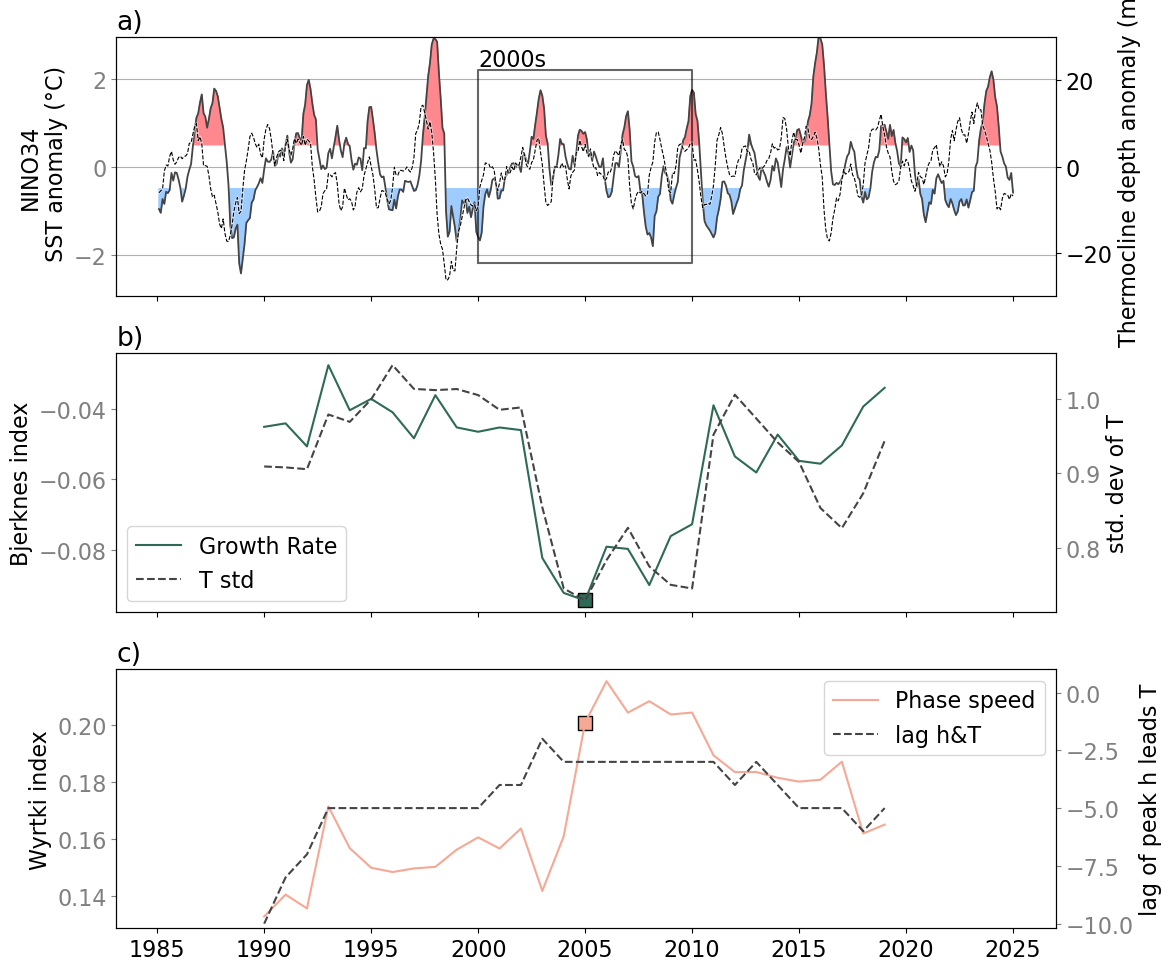

In [9]:
fig, axs = plt.subplots(3,1,figsize=(12,10),sharex='col')
for i in range(3):
    axs[i].tick_params(axis='y', colors='grey')

plt.sca(axs[0])
plt.title('a)',loc='left')
#plt.title('timeseries',loc='left')
plt.grid(axis='y',zorder=-10)
decyear = (T['time.year']+T['time.month']/12)
plt.plot(decyear,T,c='#444444',linewidth=1.3,zorder=6)
th = 0.5#nino34.std() # colouring threshold

plt.fill_between(decyear,xr.zeros_like(decyear)-th,T.where(T<-th),color=LNC,zorder=5)
plt.fill_between(decyear,xr.zeros_like(decyear)+th,T.where(T>th),color=ENC,zorder=5)

plt.plot((2000,2010,2010,2000,2000),np.array((-2,-2,2,2,-2))*1.1,alpha=0.6,linewidth=1.5,c='k',zorder=6)
plt.text(2000,2.3,'2000s',)

plt.ylabel('NINO34\n SST anomaly (°C)')
#plt.xlabel('year')
plt.ylim(-2.95,2.95)

ax02 = axs[0].twinx()
plt.sca(ax02)
plt.plot(decyear,h,c='w',linewidth=2,alpha=0.5,zorder=5.9) #This seems dumb, Jemma
plt.plot(decyear,h,c='k',linestyle='dashed',linewidth=0.8,zorder=6) #This seems dumb, Jemma
plt.ylim(-30,30)
plt.ylabel('Thermocline depth anomaly (m)')

plt.sca(axs[1])
plt.title('b)',loc='left')
#plt.title('amplitude metrics of a rolling decade',loc='left')
rolling_window_year = start_years+5 # This is the centre if you treat years as the start of the year?
lns1 = plt.plot(rolling_window_year,bj_10,label='Growth Rate',c=BJC,linewidth=1.5)
plt.scatter(rolling_window_year[-15],bj_10[-15],100,
            marker='s',facecolor=BJC,edgecolor='k',linewidth=1)
            #marker='o',facecolor='None',edgecolor='k',linewidth=2)
#plt.text(2001,np.real(eig_10)[-9],'2000s',)
plt.ylabel('Bjerknes index')
#plt.yticks([])
ax12 = axs[1].twinx()
ax12.tick_params(axis='y', colors='grey')
plt.sca(ax12)
lns2 = plt.plot(rolling_window_year,amp_10,c='#444444',label='T std',linestyle='dashed')
plt.ylabel('std. dev of T')
# ax13 = axs[1].twinx()
# plt.sca(ax13)
# lns3 = plt.plot(decyear,h.rolling(time=120,center=True).std(),c='k',linestyle='dashed',linewidth=0.8,label='h std')
# ax13.tick_params(axis="y", pad=40)
# plt.ylabel('h standard deviation')
# added these three lines
lns = lns1+lns2#+lns3
labs = [l.get_label() for l in lns]
axs[1].legend(lns, labs, loc=0)



plt.sca(axs[2])

plt.title('c)',loc='left')
#plt.title('periodicity metrics of a rolling decade',loc='left')
lns1 = plt.plot(rolling_window_year,wk_10,label='Phase speed',c=WKC,linewidth=1.5)
plt.scatter(rolling_window_year[-15],wk_10[-15],100,
            marker='s',facecolor=WKC,edgecolor='k',linewidth=1)
            #marker='o',facecolor='None',edgecolor='k',linewidth=2)
#plt.text(2001,np.imag(eig_10)[-9],'2000s',)

plt.ylabel('Wyrtki index')
#plt.yticks([])
#plt.ylim(0.12,0.26)
ax12 = axs[2].twinx()
ax12.tick_params(axis='y', colors='grey')
plt.sca(ax12)
lns2 = plt.plot(rolling_window_year,lag_10,c='#444444',label='lag h&T',linestyle='dashed')
plt.ylabel('lag of peak h leads T')
plt.ylim(-10.2,1)

lns = lns1+lns2
labs = [l.get_label() for l in lns]
axs[2].legend(lns, labs, loc=0)
plt.subplots_adjust(hspace=0.1)

plt.tight_layout()